Será gerado output codes de tamanho 3 bits para dados com 3 classes diferentes e canônicas.
Gerando modelo para bit #1 do output code...


C:\Users\Fabiano\Documents\Projeto-OML\CLogDKPd_MGmB.py:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Gerando modelo para bit #2 do output code...
Gerando modelo para bit #3 do output code...
Accuracy: 0.86


C:\Users\Fabiano\Documents\Projeto-OML\CLogDKPd_MGmB.py:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


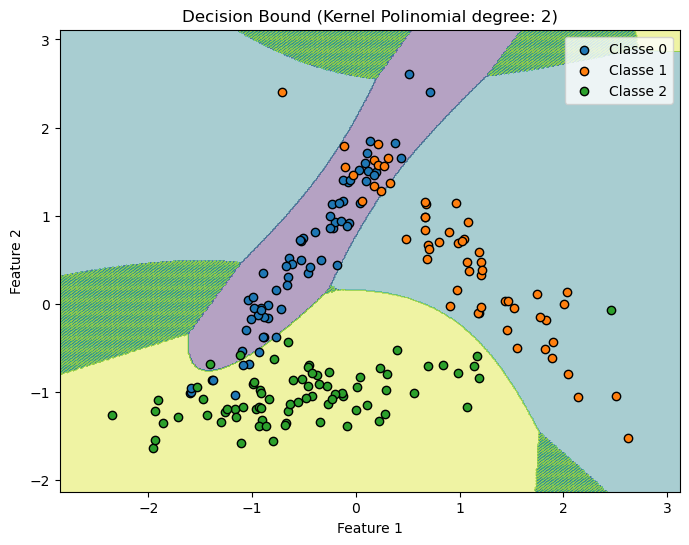

Accuracy: 0.88


C:\Users\Fabiano\Documents\Projeto-OML\CLogDKPd_MGmB.py:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


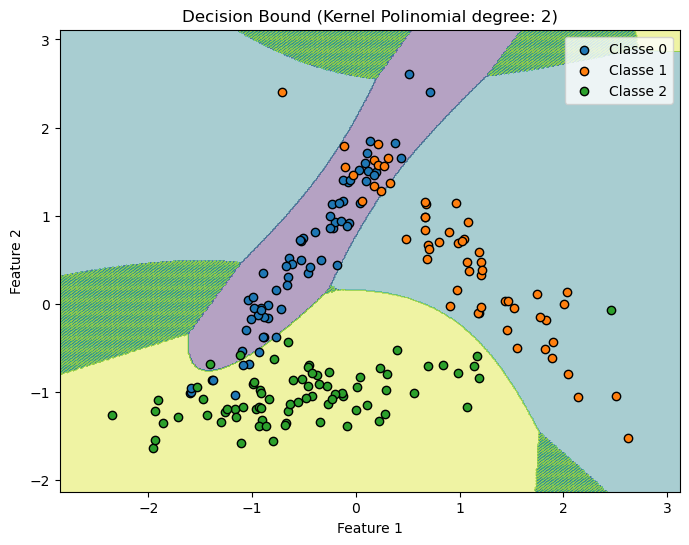

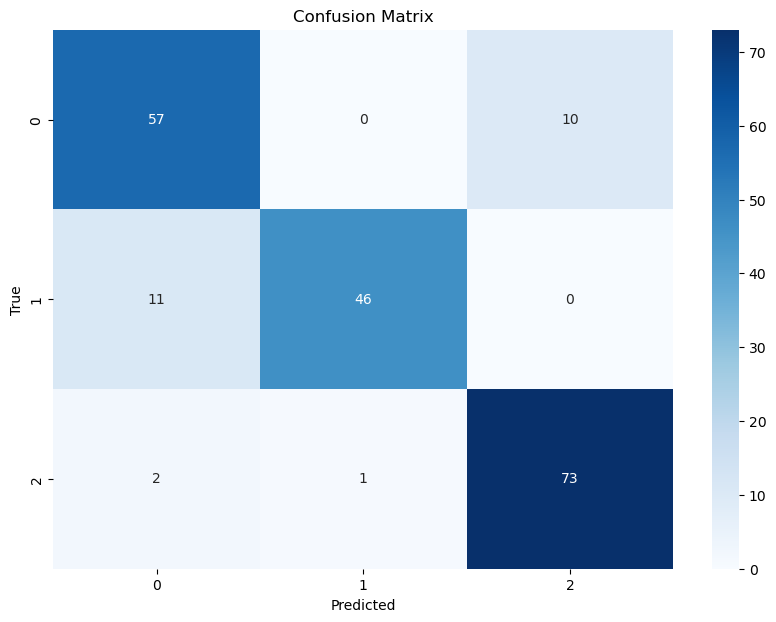

In [1]:
# TODO: pode-se pensar em retornar o count de classes mais próximas para cada evento, para ajudar a entender os erros durante análise da matriz de confusão.
# TODO: fazer busca de tabelas de output codes com média maior de distância de Hamming entre pares para tentar melhorar accuracy (código buscaTabelaEcoc.py) 

from CLogDKPd_MGmB import CLogDKPd_MGmB
from CLog_MGmB import CLog_MGmB
from utils import plot_decision_boundary
from scipy.spatial.distance import cdist
import numpy as np

class CLog_Ecoc():
    def __init__(self, n_iter=1000, batch_size=None, kernel=1, step=0.01, mode='primal', iterative=False):
        """
        Initialize the CLog_Ecoc classifier.
        Parameters:
            n_iter : int, optional (default=1000)
                Number of iterations for the optimization algorithm.
            batch_size : int, optional (default=None)
                Size of the mini-batch for stochastic gradient descent. if None, uses the entire dataset for each iteration.
            kernel : int, optional (default=1)
                Degree of the polynomial kernel.
            step : float, optional (default=0.01)
                Learning rate for the optimization algorithm.
            mode : str, optional (default='primal')
                Mode of the classifier. 'primal' for primal form, 'dual' for dual form.
            iterative : bool, optional (default=False)
                If True, uses an iterative approach for gradient descent. Sets batch_size to 1.
        """
        self.n_iter = n_iter
        self.models = []
        self.classes_ = None
        self.codes = None
        self.classesCanonicas = None #True indica que as classes presentes em Y são os elementos de range(self.classes), ie, estão no intervalo [0..n]
        self.batch_size = batch_size if not iterative else 1
        self.kernel = kernel if mode == 'dual' else 1
        self.step = step
        self.mode = mode
        self.iterative = iterative
    
    def fit(self, X, y):
        """
        Error-Correcting Output Codes (Ecoc) classification using CLogDKPd_MGmB or CLog_MGmB.
        Parameters:
            X : array-like, shape (n_samples, n_features)
                Training data.
            y : array-like, shape (n_samples,)
                Target labels.
        """
        # get the number of classes
        self.classes_ = sorted(set(y))
        qclasses = len(self.classes_)
        self.classesCanonicas = ( self.classes_ == sorted(set(range(qclasses))) )
        if qclasses >= 2 and qclasses <= 7: #sugestão de code design no artigo pdf "Error-Correcting Output Codes"
            qbits = (2**(qclasses-1)) - 1
            self.codes = [np.ones(qbits)]
            for i in range(1, qclasses):
                code = np.zeros(qbits)
                tbits = int((qbits + 1) / (2**i))
                for j in range(tbits, qbits, tbits*2):
                    code[j:j+tbits] = 1
                self.codes.append(code)
            self.codes = np.array(self.codes).astype(int)
        else:
            raise ValueError(f"Quantidade de classes {len(self.classes_)} inaceitável para Ecoc, deve ser entre 2 e 7.")

        if self.classesCanonicas:
            y_ind = y
        else:
            # Map class labels to indices
            class_to_index = {cls: idx for idx, cls in enumerate(self.classes_)}
            classToIndex = [-1] * (max(class_to_index.keys()) + 1) #convertendo o dicionário class_to_index em uma lista, ex: {0: 0, 2: 1, 3: 2} para [0, -1, 1, 2]
            # Preenche os valores definidos no dicionário
            for k, v in class_to_index.items():
                classToIndex[k] = v
            classToIndex = np.array(classToIndex).astype(int)
            y_ind = classToIndex[y]

        # create a list of models for each pair of classes
        self.models = []
        qbits = len(self.codes[0])
        print(f"Será gerado output codes de tamanho {qbits} bits para dados com {qclasses} classes diferentes{' e canônicas' if self.classesCanonicas else ''}.")
        for bit in range(qbits):
            # create a error code classifier for each bit
            y_bit = np.array(self.codes[y_ind,bit])

            if self.mode == 'primal':
                model = CLog_MGmB(n_iter=self.n_iter, batch_size=self.batch_size, learning_rate=self.step, iterative=self.iterative)
            else:
                model = CLogDKPd_MGmB(n_iter=self.n_iter, batch_size=self.batch_size, kernel=self.kernel, learning_rate=self.step, iterative=self.iterative)

            # fit the model
            print(f"Gerando modelo para bit #{1+len(self.models)} do output code...")
            model.fit(X, y_bit)
            self.models.append(model)
        return self
    
    def predict(self, X, use_best_parametes = False, rand = False):
        """
        Predict the class labels for the input data.
        Parameters:
        X : array-like, shape (n_samples, n_features)
            Input data.
        Returns:
        y_pred : array, shape (n_samples,)
            Predicted class labels.
        """
        n_samples = X.shape[0]

        # For each model, get the predicted probabilities and update the votes
        code = []
        for model in self.models:
            code.append(model.predict_proba(X, use_best_parametes = use_best_parametes))

        #code = np.round(np.array(code)).astype(int).T
        code = np.array(code).T
        icode = np.round(code).astype(int)
        # Return the class with the most the output code closer by Hamming distance
        distances = cdist(icode, self.codes, metric='hamming') * self.codes.shape[1]
        min_value = distances.min(axis=1, keepdims=True)

        escolhido = distances.argmin(axis=1)
        closerClasses = distances.argmin(axis=1)
        count = np.sum(distances == min_value, axis=1)
        if count.max() > 1: #Houve pelo menos um empate
            for i, qclasses in enumerate(count): # analisa cada evento em que pode ter havido empate de mais de uma classe y^
                if qclasses <= 1: # não houve empate
                    continue
                #houve empate, então escolho a classe empatada com a menor distância sum(abs(p^ - code)), ao invés de usar a métrica hamming com y^
                indices = np.where(distances[i] == min_value[i])[0]
                if rand:
                    escolhido = indices[i % len(indices)]
                else:
                    fdistances = np.sum(np.abs(self.codes[indices] - code[i]), axis=1)
                    escolhido = fdistances.argmin()
                    ncount = np.sum(fdistances == fdistances[escolhido])
                    if ncount > 1: # se mesmo usando p^ para calcular a distância mínima ainda há empate, então escolhe aleatoriamente uma das classes empatadas
                        indices = np.where(fdistances == fdistances[escolhido])[0]
                        escolhido = indices[i % len(indices)] #aleatorio de acordo com a posição do evento! Mais agradável por formar hachurado na meshgrid!
                        #escolhido = np.random.choice(indices) 
                        #print("Houve um empate!", i, ncount, code[i], distances[i], min_value[i], np.abs((self.codes[indices]) - code[i]), indices, fdistances, escolhido)
                    else:
                        escolhido = indices[escolhido]
                        #print("Houve um empate!", i, ncount, code[i], distances[i], min_value[i], np.abs((self.codes[indices]) - code[i]), indices, fdistances, escolhido)

                closerClasses[i] = escolhido
        
        if not self.classesCanonicas: # Map indices to class labels
            closerClasses = np.array(self.classes_)[closerClasses]
        return closerClasses
    
    def get_errors(self):
        """
        Get the errors of each model.
        Returns:
        errors : list
            List of errors for each model.
        """
        errors = []
        for model in self.models:
            errors.append(model.get_errors())
        return errors
    

if __name__ == "__main__":
    import numpy as np
    from sklearn.datasets import make_classification, make_blobs, make_moons
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score

    # Generate a synthetic dataset
    #X, y = make_classification(n_samples=1000,
    #                         n_features=2,
    #                         n_informative=2,
    #                         n_redundant=0,
    #                         n_clusters_per_class=1,
    #                         class_sep=0.95,        # separação pequena → mais difícil
    #                         n_classes=4,
    #                         random_state=12)
    #X, y = make_classification(n_samples=1000, n_features=784, n_classes=3, n_informative=500, random_state=42)
    X, y = make_classification(n_samples=1000, n_features=2, n_classes=3, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
    #X, y = make_classification(n_samples=1000, n_features=2, n_classes=3, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
    #X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
    #X, y = make_classification(n_samples=200, n_features=2, n_classes=4, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
    
    # y[y == 2] = 3 #descomente para testar classe não canônicas

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Normalize the data
    train_std = np.std(X_train, axis=0)
    train_mean = np.mean(X_train, axis=0)
    X_train = (X_train - train_mean) / train_std
    X_test = (X_test - train_mean) / train_std

    # Create an instance of the CLog_Ecoc classifier
    clf = CLog_Ecoc(n_iter=5000, batch_size=1, kernel=2, step=0.001, mode='dual', iterative=True)

    # Fit the model on the training data
    clf.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(X_test, rand=True)
    #pribt probs
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Plot the decision boundary
    plot_decision_boundary(clf, X_test, y_test,500, rand=True)

    # Make predictions on the test data
    y_pred = clf.predict(X_test, rand=False)
    #pribt probs
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Plot the decision boundary
    plot_decision_boundary(clf, X_test, y_test,500, rand=False)

    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # # teste with sklearn classifier
    # from sklearn.linear_model import LogisticRegression
    # clf_sklearn = LogisticRegression(max_iter=5000)
    # clf_sklearn.fit(X_train, y_train)
    # y_pred_sklearn = clf_sklearn.predict(X_test)
    # accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)
    # print(f"Accuracy sklearn: {accuracy_sklearn:.2f}")